In [6]:
from ase.io import read
import matplotlib.pyplot as plt

import abtem

# Multislice simulations

The multislice algorithm works by propagating the $xy$ part of the wave function slice-by-slice forward along the optical axis (which in abTEM is by definition the positive $z$ direction). A forward step through a slice of the potential consists of a transmission and a propagation. In the weak-phase approximation the transmission through a slice is just a phase shift proportional to the magnitude of the potential within that. To complete the multislice step, the transmitted wave is propagated by a distance corresponding to the thickness of the slice using the Fresnel free-space approximation.

Below we create a `Potential` and a `PlaneWave`:

In [7]:
atoms = read('data/srtio3_110.cif')

potential = abtem.Potential(atoms, slice_thickness=1)

wave = abtem.PlaneWave(energy=300e3, sampling=.05)

We create a task graph for running a simulation with the multislice algorithm with the `.multislice` method.

In [5]:
pw_exit_wave = wave.multislice(potential)

To execute the task graph, we call `.compute`.

In [6]:
pw_exit_wave.compute();

We can now show the resulting exit wave. By default we show the intensity.

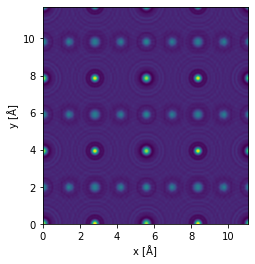

In [24]:
pw_exit_wave.show();

We can write the wave function to disk and load it again.

In [6]:
pw_exit_wave.to_zarr('data/srtio3_110_exit_wave.zarr', overwrite=True)

imported_wave = abtem.from_zarr('data/srtio3_110_exit_wave.zarr')

assert imported_wave == pw_exit_wave

The electron diffraction pattern can be obtained using the `.diffraction_patterns` method. We set `block_direct=True` since the direct beam often has much higher intensity than the scattered beams and thus we can't show it on the same scale.

In [7]:
pw_diffraction_pattern = pw_exit_wave.diffraction_patterns(block_direct=True)

We show the diffraction pattern.

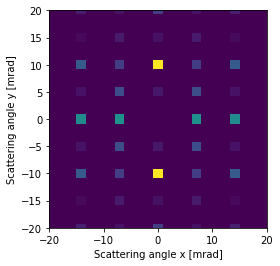

In [8]:
ax, im = pw_diffraction_pattern.show(angular_units=True)

ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20]);

It may be unexpected that the diffraction spot looks like squares, this is because the incoming beam is a periodic infinite plane wave, which means that the diffraction spots are single points. However, we are discretizing the wave function on a square grid (i.e. pixels), hence the spots can only be as small as single pixels.

<div class= "alert alert-info">

**Note: Undefined or inconsistent grids**

You may have noted that the grid of the wave function was not given above. 
When using a wave function in conjuntion with a potential, the wave function will adopt the grid of the potential. On the other hand, the following will result in an error because the sampling cannot be inferred from the information given.

```python
wave = PlaneWave(energy=300e3)
potential = Potential(atoms)
exit_wave = wave.multislice(potential)
```

The next lines will just result in a warning because the sampling of the wave function and the potential is different. The simulation task graph will be created using the grid of the potential.

```python
wave = PlaneWave(sampling=.1, energy=300e3)
potential = Potential(atoms, sampling=.05)
exit_wave = wave.multislice(potential)
```
    
</div>

## Multislice simulation with probe
For a probe, we need to provide the convergence semiangle (in mrad) via `semiangle_cutoff`.

In [9]:
probe = abtem.Probe(energy=100e3, semiangle_cutoff=20)

We want to position the probe on an atom hence we obtain the `xy` position of one of the atoms.

In [10]:
position = atoms.positions[200][:2]

position

array([5.5225    , 7.81003905])

We then simulate the exit wave via a multislice simulation of the probe placed at this position.

In [11]:
probe_exit_wave = probe.multislice(scan=position, potential=potential)

probe_exit_wave.compute()

c:\users\jacob\pycharmprojects\abtem_dask\abtem\waves\waves.py:140: UserWarning: normalization not provided, aussming Fourier space normalization
  warnings.warn('normalization not provided, aussming Fourier space normalization')


The convergent-beam electron diffraction (CBED) pattern can be calculated in the same manner as the ED pattern. We again display the result on a log scale. Note that to get more useful results, we should go back and increase our sampling of the potential.

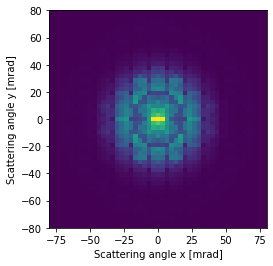

In [12]:
cbed_diffraction_pattern = probe_exit_wave.diffraction_patterns()

ax, im = cbed_diffraction_pattern.show(angular_units=True, max_angle=80)

## Thickness series
CBED is often used for determining sample the thickness by comparing an experiment to a thickness series. 


In [28]:
potential = abtem.Potential(atoms, slice_thickness=1, exit_planes=2)

wave = abtem.PlaneWave(energy=300e3, sampling=.05)

In [29]:
exit_waves = wave.multislice(potential)

exit_waves.compute()

In [87]:
diffraction_patterns = exit_waves[::3].diffraction_patterns(max_angle=30).block_direct()

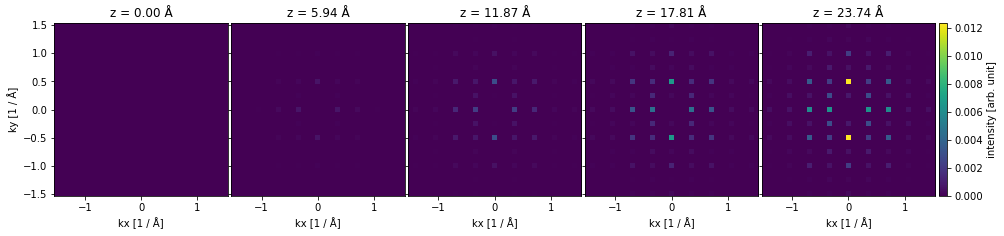

In [91]:
diffraction_patterns.show(explode = True, 
                          figsize = (16, 6),
                          common_color_scale = True,
                          cbar = True,
                          image_grid_kwargs = {'axes_pad': .05},
                          )